In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import cufflinks as cf
import plotly.offline as py
import warnings
warnings.simplefilter("ignore")
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression, Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.metrics import r2_score,mean_squared_error

In [152]:
main_df=pd.read_csv(r"C:\Users\abhisv.CORP\3D Objects\Bigmart\train_v9rqX0R.csv")

In [153]:
main_df.shape

(8523, 12)

In [154]:
main_df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27


As per the problem statement, we are suppose to find item outlet sales, means each item in that particular outlet what is the sales happening. So just with common understanding we should have item and outlet information, which is given by client.
So we have multiple attributes w.r.t to item and outlet, if we look closely into each attribute we can think we require all the variables, i dont think we need to drop any of them.
But still we may ignore few columns later, will see.

Data have both numerical and categorical columns, so lets analyse them

In [60]:
numerical=main_df.describe().columns
print(numerical)

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')


In [155]:
main_df[numerical].head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,9.30,0.02,249.81,1999
1,5.92,0.02,48.27,2009
2,17.50,0.02,141.62,1999
3,19.20,0.00,182.09,1998
4,8.93,0.00,53.86,1987


In [156]:
cat=[]
for i in main_df:
    if i not in numerical:
        cat.append(i)

print(cat)

['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']


In [157]:
numerical.shape[0],len(cat)

(4, 8)

In [158]:
main_df[cat].head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1,3735.14
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store,732.38
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1,994.71


In [159]:
main_df[numerical].isna().sum()

Item_Weight                  1463
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
dtype: int64

In [160]:
#lets create a function for null value treatment, here am planing to drop a column with null values greater than 30%.

In [161]:
def nullvaluetreat(main_df):
    nullvaluecols=(main_df.isna().sum()/len(main_df))*100
    print(nullvaluecols)
    drop_cols=nullvaluecols[nullvaluecols>int(input())].index
    print(drop_cols)
    retained_cols=nullvaluecols[nullvaluecols<int(input())].index
    print(len(retained_cols))
    numerical=main_df.describe().columns
    cat=[]
    for i in main_df:
        if i not in numerical:
            cat.append(i)
    for i in cat:
        main_df[i].fillna(main_df[i].value_counts().index[0],inplace=True)
    for i in numerical:
        main_df[i].fillna(main_df[i].median(),inplace=True)
    print(main_df.isna().sum())
    return main_df,cat,numerical
        

In [162]:
#As many industries drop a col if the null value percentage is greater than 30, but here we can see none of the columns are greater than 30, will treat them seperately.

In [163]:
main_df,cat,numerical=nullvaluetreat(main_df)

Item_Identifier              0.00
Item_Weight                 17.17
Item_Fat_Content             0.00
Item_Visibility              0.00
Item_Type                    0.00
Item_MRP                     0.00
Outlet_Identifier            0.00
Outlet_Establishment_Year    0.00
Outlet_Size                 28.28
Outlet_Location_Type         0.00
Outlet_Type                  0.00
Item_Outlet_Sales            0.00
dtype: float64
30
Index([], dtype='object')
30
12
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


In [164]:
cat

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [165]:
main_df['Item_Identifier'].nunique()# item identifier is also not important, lets drop it

1559

In [166]:
main_df['Item_Fat_Content'].nunique()#I dont think if fat content contribute much

5

In [167]:
main_df['Item_Type'].nunique()#Lets drop it

16

In [168]:
main_df['Outlet_Identifier'].nunique()#Lets drop it

10

In [169]:
main_df['Outlet_Size'].nunique()#If outlet is big, more sales will happen lets include it

3

In [170]:
main_df['Outlet_Location_Type'].nunique()#Lets lable encode it

3

In [171]:
main_df['Outlet_Type'].nunique()#Label encode it

4

In [172]:
main_df['Outlet_Size'].nunique()#Label encode it

3

In [173]:
main_df.drop(['Item_Identifier','Item_Type','Item_Fat_Content','Item_Type','Outlet_Identifier'],axis=1,inplace=True)

In [174]:
main_df.shape

(8523, 8)

In [175]:
main_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0.02,249.81,1999,Medium,Tier 1,Supermarket Type1,3735.14
1,5.92,0.02,48.27,2009,Medium,Tier 3,Supermarket Type2,443.42
2,17.50,0.02,141.62,1999,Medium,Tier 1,Supermarket Type1,2097.27


In [176]:
main_df['Outlet_Size'].value_counts()

Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [177]:
main_df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [178]:
main_df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [179]:
cat1=[]
for i in main_df:
    if i not in numerical:
        cat1.append(i)


In [180]:
#As remianing categorical columns fallowing ordinal class, lets do label encoding

In [87]:
def labelencoder(main_df,cat1):
    le=LabelEncoder()
    for i in cat1:
        le.fit(main_df[i])
        x=le.transform(main_df[i])
        main_df[i]=x
    return main_df

In [88]:
labelencoded=labelencoder(main_df,cat1)

In [89]:
pd.options.display.float_format = '{:.2f}'.format

In [90]:
outlet_Establishment_Year_df=main_df.groupby('Outlet_Establishment_Year')[['Item_Outlet_Sales']].sum()

In [91]:
outlet_Establishment_Year_df=outlet_Establishment_Year_df.reset_index()

Text(0.5, 1.0, 'Sales over year')

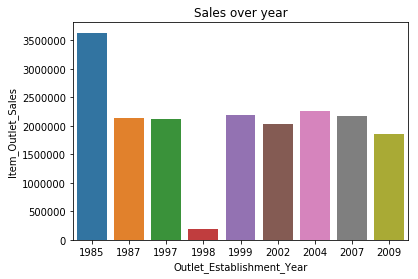

In [92]:
sns.barplot(outlet_Establishment_Year_df['Outlet_Establishment_Year'],outlet_Establishment_Year_df['Item_Outlet_Sales'],)
plt.title('Sales over year')

In [93]:
main_df.head(1)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0.02,249.81,1999,1,0,1,3735.14


In [94]:
df_Outlet_Location_Type=main_df.groupby('Outlet_Location_Type')[['Item_Outlet_Sales']].sum()

In [95]:
df_Outlet_Location_Type=df_Outlet_Location_Type.reset_index()

In [96]:
df_Outlet_Location_Type

,Outlet_Location_Type,Item_Outlet_Sales
0,0,4482059.07
1,1,6472313.71
2,2,7636752.63


([<matplotlib.patches.Wedge at 0x21b0a6a5e10>,
 [Text(0.799291851002638, 0.755733112229957, ''),
  Text(-0.9473644350704333, 0.5590175553269137, ''),
  Text(0.3043206902755429, -1.0570661840538733, '')],
 [Text(0.43597737327416614, 0.41221806121634014, '24.1%'),
  Text(-0.5167442373111454, 0.3049186665419529, '34.8%'),
  Text(0.16599310378665974, -0.5765815549384763, '41.1%')])

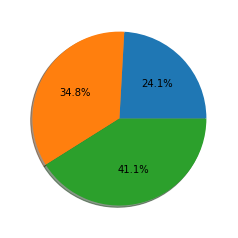

In [97]:
plt.pie(df_Outlet_Location_Type['Item_Outlet_Sales'],autopct='%1.1f%%', shadow=True)

In [98]:
#Lets check for the outleirs, by plotting distribution of Item_outlet_Sales

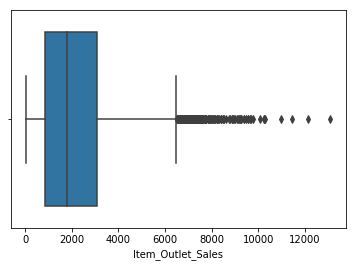

In [99]:
sns.boxplot(main_df['Item_Outlet_Sales'])

In [100]:
def outliers(main_df):
    for i in main_df.describe().columns:
        Q1=main_df.describe().at['25%',i]
        Q3=main_df.describe().at['75%',i]
        IQR=Q3-Q1
        UTV=Q3+1.5*IQR
        LTV=Q1-1.5*IQR
        y=[]
        x=np.array(main_df[i])
        for j in main_df[i]:
            if j<LTV or j>UTV:
                y.append(main_df[i].median())
            else:
                y.append(j)
        main_df[i]=y
        

In [101]:
outliers(main_df)

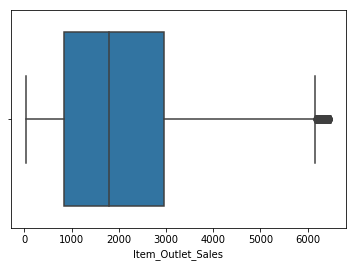

In [102]:
sns.boxplot(main_df['Item_Outlet_Sales'])

In [103]:
main_df.drop(['Outlet_Establishment_Year'],axis=1,inplace=True)

In [104]:
Y=main_df['Item_Outlet_Sales']

In [105]:
Y=pd.DataFrame(Y)

In [106]:
main_df.drop('Item_Outlet_Sales',axis=1,inplace=True)

In [107]:
X=main_df

In [131]:
rfc=RandomForestRegressor(random_state=40,n_estimators=20,min_samples_split=2,criterion='mse')
rfc.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=40, verbose=0,
                      warm_start=False)

In [132]:
Y_pred_rfc=rfc.predict(X)
accuracy_rfc=r2_score(Y,Y_pred_rfc)
print(accuracy_rfc)

0.9068892747523181


In [134]:
kf=KFold(5,shuffle=True,random_state=40)
accuraccross_val_score(rfc,X,Y,cv=kf,scoring='r2')

array([0.39593749, 0.39751312, 0.41604594, 0.41361313, 0.35175017])

In [57]:
#mse=mean_squared_error(Y,Y_pred_rfc)
#print(mse)

In [58]:
#accuracy=r2_score(Y,Y_pred_rfc)
#print(accuracy)

In [135]:
df_test1=pd.read_csv(r"C:\Users\abhisv.CORP\3D Objects\Bigmart\test_AbJTz2l.csv")

In [136]:
df_test=pd.read_csv(r"C:\Users\abhisv.CORP\3D Objects\Bigmart\test_AbJTz2l.csv")

In [137]:
df_test.shape

(5681, 11)

In [138]:
df_test,cat,numerical=nullvaluetreat(df_test)

Item_Identifier              0.00
Item_Weight                 17.18
Item_Fat_Content             0.00
Item_Visibility              0.00
Item_Type                    0.00
Item_MRP                     0.00
Outlet_Identifier            0.00
Outlet_Establishment_Year    0.00
Outlet_Size                 28.27
Outlet_Location_Type         0.00
Outlet_Type                  0.00
dtype: float64
30
Index([], dtype='object')
30
11
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64


In [139]:
df_test.drop(['Item_Identifier','Item_Type','Item_Fat_Content','Item_Type','Outlet_Identifier'],axis=1,inplace=True)

In [140]:
cat1=[]
for i in df_test:
    if i not in numerical:
        cat1.append(i)


In [141]:
labelencoded=labelencoder(df_test,cat1)

In [142]:
outliers(df_test)

In [143]:
df_test.drop(['Outlet_Establishment_Year'],axis=1,inplace=True)

In [144]:
df_test_pred=rfc.predict(df_test)

In [145]:
df_test_pred=pd.DataFrame(df_test_pred)

In [146]:
df_test_pred.to_csv('sample_submission2.csv',index=False)

In [147]:
df_test1[['Item_Identifier','Outlet_Identifier']].to_csv('submission3.csv',index=False)

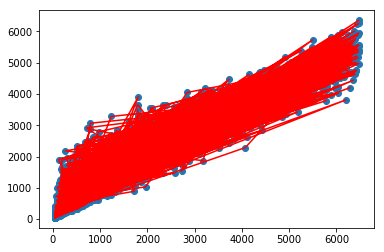

In [150]:
plt.scatter(Y, Y_pred_rfc)
plt.plot(Y, Y_pred_rfc,color='red')